# Problem Set 3

In [1]:
# imports
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy.stats import shapiro, bartlett
from matplotlib import pyplot as plt
import pandas

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
def set_fontsize(ax,fsz):
    """
    Set the fontsize throughout an Axis
    
    Args:
        ax (Matplotlib Axis): 
        fsz (float): Font size

    Returns:

    """
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fsz)


# Question 1

## Load data

### SIO

In [3]:
SIO_file = '../Data/SIO_SST.txt'

In [4]:
SIO_df = pandas.read_table(SIO_file, delim_whitespace=True)
SIO_df.head()

,year,SST
0,1916,15.642
1,1917,16.743
2,1918,17.385
3,1919,16.810
4,1920,16.576


### Dates

In [19]:
dates = []
for index, row in SIO_df.iterrows():
    dates.append(f'{int(row.year)}')
dates = pandas.to_datetime(dates)
SIO_df['date'] = dates
SIO_df.set_index('date', inplace=True)
# Remove Year
SIO_df.drop(columns='year', inplace=True)
SIO_df.head()

,SST
date,
1916-01-01,15.642
1917-01-01,16.743
1918-01-01,17.385
1919-01-01,16.810
1920-01-01,16.576


### PDO

In [6]:
PDO_file = '../Data/ersst.v5.pdo.dat'

In [7]:
PDO_df = pandas.read_table(PDO_file, delim_whitespace=True)
PDO_df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1854,0.11,-0.24,-0.40,-0.44,-0.54,-0.30,-0.10,-1.24,-1.00,-2.23,-1.68,-1.76
1,1855,-0.20,-0.39,-0.24,-0.58,-1.34,-1.88,-1.13,-0.48,-0.76,-0.63,-0.41,-0.88
2,1856,-0.39,0.47,0.42,-0.96,-1.26,-2.15,-0.69,0.63,0.58,0.59,0.23,0.04
3,1857,-0.52,-1.67,-1.05,-0.81,-0.65,1.03,1.17,0.81,0.84,0.70,0.38,-0.55
4,1858,-0.96,-1.53,-1.76,-0.82,0.49,2.19,1.05,0.67,1.38,2.35,0.46,-1.16


#### Date

In [15]:
dates = []
for index, row in PDO_df.iterrows():
    dates.append(f'{int(row.Year)}')
dates = pandas.to_datetime(dates)
PDO_df['date'] = dates
PDO_df.set_index('date', inplace=True)
# Remove Year
PDO_df.drop(columns='Year', inplace=True)
PDO_df.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
date,,,,,,,,,,,,
1854-01-01,0.11,-0.24,-0.40,-0.44,-0.54,-0.30,-0.10,-1.24,-1.00,-2.23,-1.68,-1.76
1855-01-01,-0.20,-0.39,-0.24,-0.58,-1.34,-1.88,-1.13,-0.48,-0.76,-0.63,-0.41,-0.88
1856-01-01,-0.39,0.47,0.42,-0.96,-1.26,-2.15,-0.69,0.63,0.58,0.59,0.23,0.04
1857-01-01,-0.52,-1.67,-1.05,-0.81,-0.65,1.03,1.17,0.81,0.84,0.70,0.38,-0.55
1858-01-01,-0.96,-1.53,-1.76,-0.82,0.49,2.19,1.05,0.67,1.38,2.35,0.46,-1.16


#### Average

In [18]:
PDO_df['average'] = PDO_df.sum(axis=1).values / 12.
PDO_df.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,average
date,,,,,,,,,,,,,
1854-01-01,0.11,-0.24,-0.40,-0.44,-0.54,-0.30,-0.10,-1.24,-1.00,-2.23,-1.68,-1.76,-0.818333
1855-01-01,-0.20,-0.39,-0.24,-0.58,-1.34,-1.88,-1.13,-0.48,-0.76,-0.63,-0.41,-0.88,-0.743333
1856-01-01,-0.39,0.47,0.42,-0.96,-1.26,-2.15,-0.69,0.63,0.58,0.59,0.23,0.04,-0.207500
1857-01-01,-0.52,-1.67,-1.05,-0.81,-0.65,1.03,1.17,0.81,0.84,0.70,0.38,-0.55,-0.026667
1858-01-01,-0.96,-1.53,-1.76,-0.82,0.49,2.19,1.05,0.67,1.38,2.35,0.46,-1.16,0.196667


#### Cut on year

In [33]:
gd_PDO = (PDO_df.index >= SIO_df.index[0]) & (PDO_df.index <= SIO_df.index[-1])

In [34]:
cut_PDO_df = PDO_df[gd_PDO].copy()

In [35]:
len(SIO_df), len(cut_PDO_df)

(105, 105)

## Plot

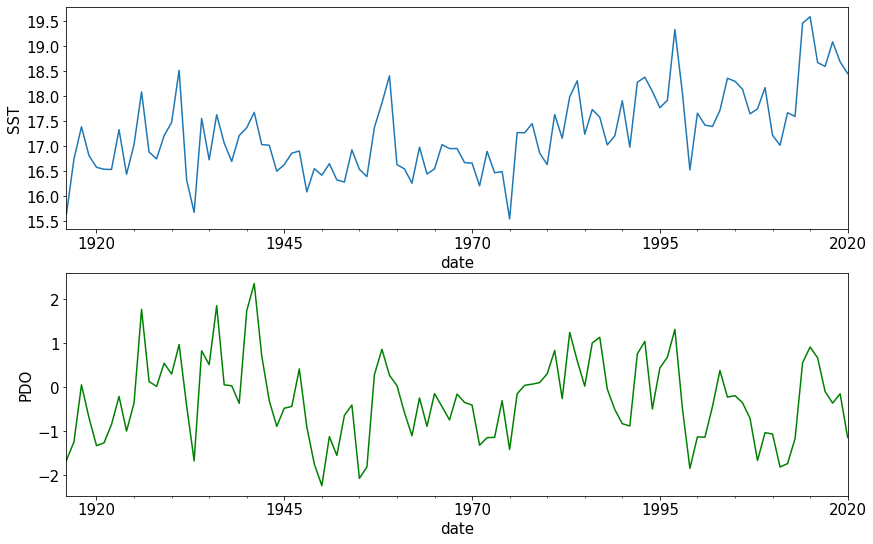

In [37]:
fig, axs = plt.subplots(2)
fig.set_size_inches((14, 9))
# SIO
SIO_df.SST.plot(ax=axs[0], ylabel='SST')
# PDO
cut_PDO_df.average.plot(ax=axs[1], ylabel='PDO', color='green')
# Fons
for ax in axs:
    set_fontsize(ax, 15)
# Save
plt.savefig('PS3_Q1.png', dpi=300)

----

# Question 2

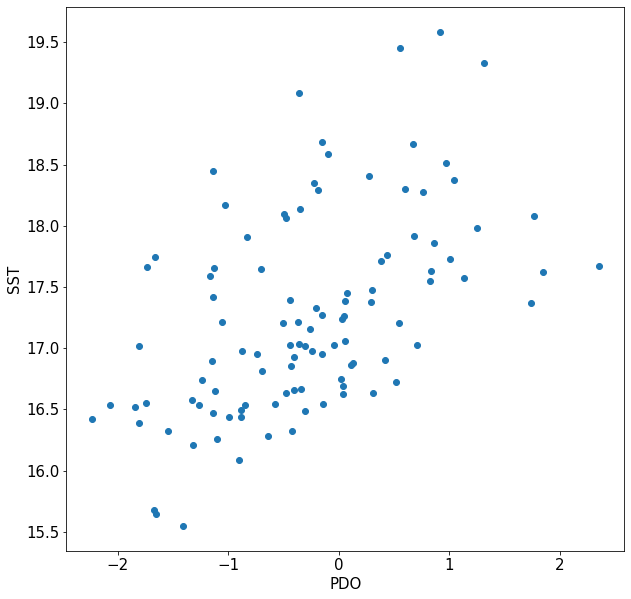

In [50]:
fig = plt.figure(figsize=(10,10))
ax=plt.gca()
ax.plot(cut_PDO_df.average, SIO_df.SST, 'o')
ax.set_xlabel('PDO')
ax.set_ylabel('SST')
#
set_fontsize(ax, 15.)
#
plt.savefig('PS3_Q2.png', dpi=300)

----

# Question 3

## I observe a positive correlation, albeit with significant scatter

## It appears roughly linear

----

# Question 4 -- Fit linear regression model

## Prep data

In [45]:
data = pandas.DataFrame()
data['SST'] = SIO_df.SST.values
data['PDO'] = cut_PDO_df.average.values
#

## Fit

In [46]:
basic_formula = "SST ~ PDO"
mod_basic = smf.glm(formula=basic_formula, data=data).fit()#, family=sm.f

In [47]:
mod_basic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    SST   No. Observations:                  105
Model:                            GLM   Df Residuals:                      103
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.48849
Method:                          IRLS   Log-Likelihood:                -110.37
Date:                Mon, 02 May 2022   Deviance:                       50.314
Time:                        11:28:35   Pearson chi2:                     50.3
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3104
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.3964      0.071    243.747      0.000      17.257      17.536
PDO            0.4614      0.074      6.246      0.000       0.317       0.606
==============================================================================
"""

## Plot

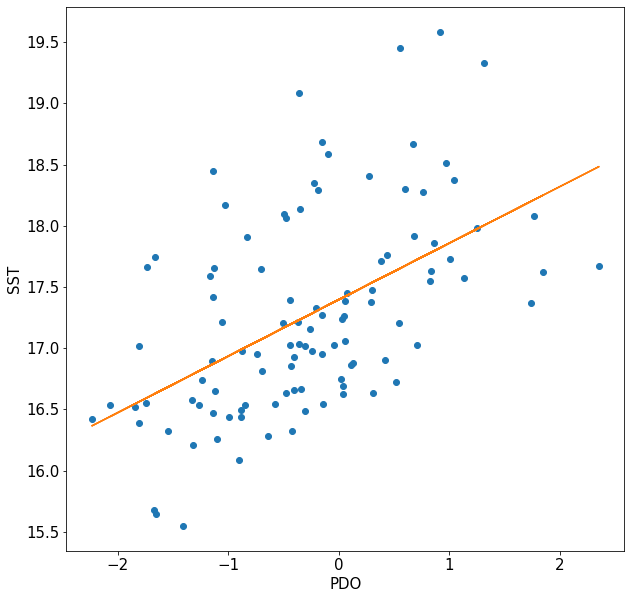

In [49]:
fig = plt.figure(figsize=(10,10))
ax=plt.gca()
# Data
ax.plot(data.PDO, data.SST, 'o')
# Model
ax.plot(data.PDO, mod_basic.fittedvalues)
# Lables
ax.set_xlabel('PDO')
ax.set_ylabel('SST')
#
set_fontsize(ax, 15.)
#
plt.savefig('PS3_Q4.png', dpi=300)

# Question 5 -- Residuals vs. time

## Residuals

In [51]:
data.index = SIO_df.index

In [52]:
data.head()

,SST,PDO
date,,
1916-01-01,15.642,-1.657500
1917-01-01,16.743,-1.240833
1918-01-01,17.385,0.056667
1919-01-01,16.810,-0.690833
1920-01-01,16.576,-1.326667


In [62]:
resids = data.SST.values - mod_basic.fittedvalues.values
data['resids'] = resids

In [65]:
data.head()

,SST,PDO,resids
date,,,
1916-01-01,15.642,-1.657500,-0.989643
1917-01-01,16.743,-1.240833,-0.080894
1918-01-01,17.385,0.056667,-0.037563
1919-01-01,16.810,-0.690833,-0.267665
1920-01-01,16.576,-1.326667,-0.208290


## Plot

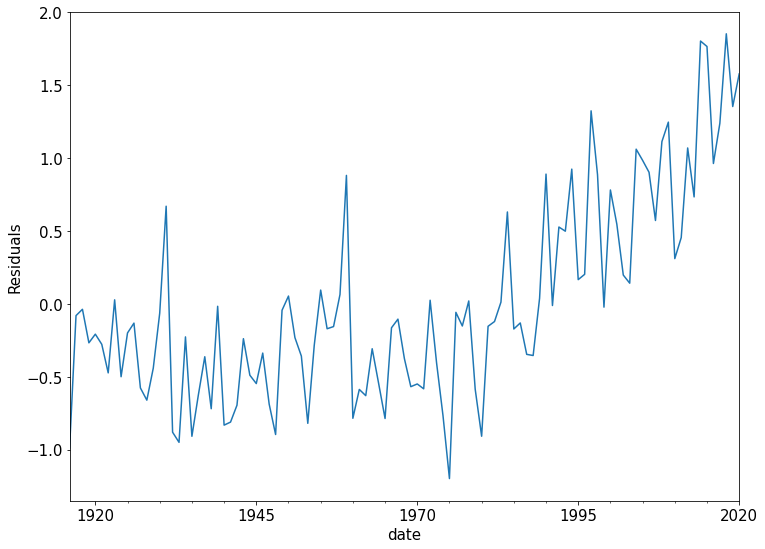

In [82]:
fig = plt.figure()
fig.set_size_inches((12, 9))
ax = data.resids.plot(ylabel='Residuals')
set_fontsize(ax, 15.)
#
plt.savefig('PS3_Q5.png', dpi=300)

----

# Question 6 -- What do you see?

## There is a clear trend of the residuals in time, with the values increasing over the past ~30 years

----

# Question 7 -- Add a linear trend in time

In [73]:
time = np.arange(len(data)) + 1
data['time'] = time

In [74]:
linear_formula = "SST ~ PDO + time"
mod_linear = smf.glm(formula=linear_formula, data=data).fit()#, family=sm.f

In [75]:
mod_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    SST   No. Observations:                  105
Model:                            GLM   Df Residuals:                      102
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                         0.25511
Method:                          IRLS   Log-Likelihood:                -75.749
Date:                Mon, 02 May 2022   Deviance:                       26.022
Time:                        11:36:45   Pearson chi2:                     26.0
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8018
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.5598      0.100    165.502      0.000      16.364      16.756
PDO            0.4785      0.053      8.959      0.000       0.374       0.583
time           0.0159      0.002      9.758      0.000       0.013       0.019
==============================================================================
"""

## R2

In [110]:
y = data.SST.values
#
sst_val = sum(map(lambda x: np.power(x,2),y-np.mean(y))) 
sse_val = sum(map(lambda x: np.power(x,2),mod_linear.resid_response)) 
r2_linear = 1.0 - sse_val/sst_val
r2_linear
adjusted_r2_linear = 1 - (1-r2)*(len(data)-1)/(len(data)-len(mod_linear.params)-1)
adjusted_r2_linear

0.6137379344839841

## The trend term is highly significant  $P(>|z|) < 0.001$

----

# Question 8 -- Residuals of linear model

In [77]:
linear_resids = data.SST.values - mod_linear.fittedvalues.values
data['linear_resids'] = linear_resids

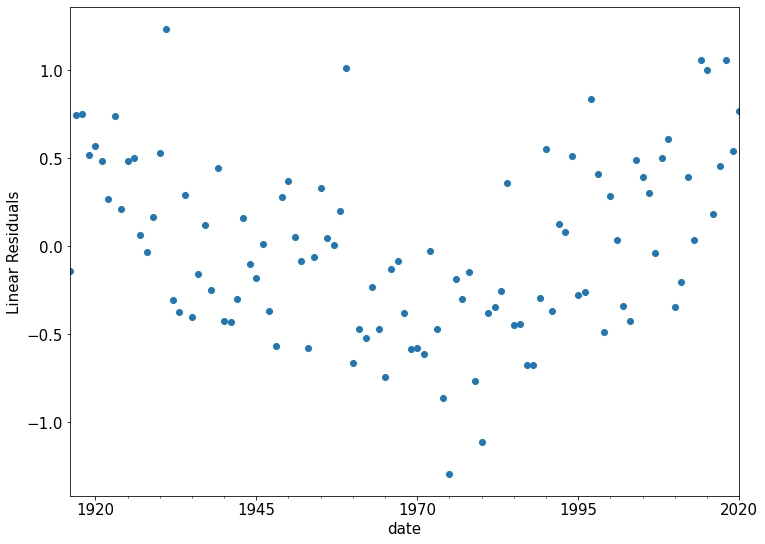

In [81]:
fig = plt.figure()
fig.set_size_inches((12, 9))
ax = data.linear_resids.plot(ylabel='Linear Residuals', marker='o', ls='')
set_fontsize(ax, 15.)
#
plt.savefig('PS3_Q8.png', dpi=300)

----

# Question 9 -- Anything concerning?

## While we have reduced the trend at the end of the time period, we have introduced one at the beginning that was not previously pesent!

----

# Question 10 -- Dummy time

In [92]:
dummy0 = np.zeros(len(data))
dummy0[data.index >= pandas.to_datetime('1989')] = 1
data['dummy0'] = dummy0
data.dummy0[-40:-30]

date
1981-01-01    0.0
1982-01-01    0.0
1983-01-01    0.0
1984-01-01    0.0
1985-01-01    0.0
1986-01-01    0.0
1987-01-01    0.0
1988-01-01    0.0
1989-01-01    1.0
1990-01-01    1.0
Name: dummy0, dtype: float64

## Fit

In [101]:
dummy0_formula = "SST ~ PDO + dummy0"
mod_dummy0 = smf.glm(formula=dummy0_formula, data=data).fit()#, family=sm.f
mod_dummy0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    SST   No. Observations:                  105
Model:                            GLM   Df Residuals:                      102
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                         0.19150
Method:                          IRLS   Log-Likelihood:                -60.691
Date:                Mon, 02 May 2022   Deviance:                       19.533
Time:                        11:50:53   Pearson chi2:                     19.5
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9162
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.0501      0.052    325.536      0.000      16.947      17.153
PDO            0.5080      0.046     10.948      0.000       0.417       0.599
dummy0         1.1800      0.093     12.678      0.000       0.998       1.362
==============================================================================
"""

In [102]:
dummy0_resids = data.SST.values - mod_dummy0.fittedvalues.values
data['dummy0_resids'] = dummy0_resids

## R2

In [109]:
y = data.SST.values
#
sst_val = sum(map(lambda x: np.power(x,2),y-np.mean(y))) 
sse_val_d0 = sum(map(lambda x: np.power(x,2),mod_dummy0.resid_response)) 
r2_dummy0 = 1.0 - sse_val_d0/sst_val
#r2_dummy0
adjusted_r2_dummy0 = 1 - (1-r2_dummy0)*(len(data)-1)/(len(data)-len(mod_dummy0.params)-1)
adjusted_r2_dummy0

0.7100564700156411

----

# Question 11 -- Dummy0 Residuals

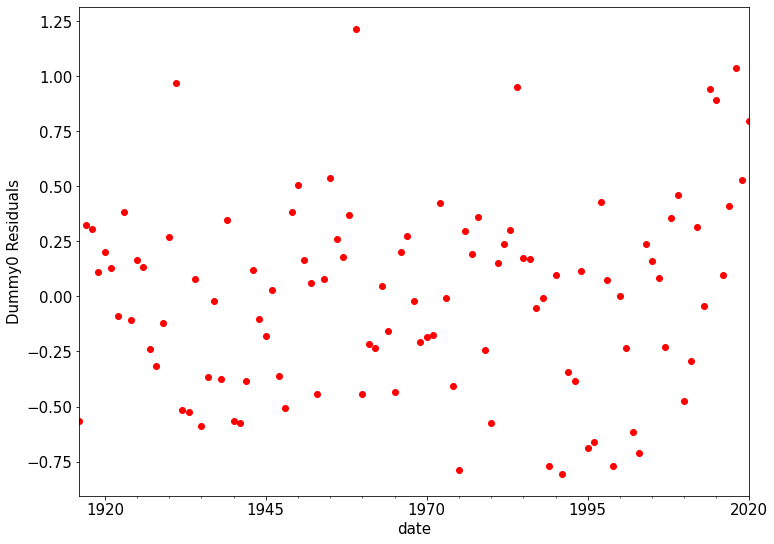

In [104]:
fig = plt.figure()
fig.set_size_inches((12, 9))
ax = data.dummy0_resids.plot(ylabel='Dummy0 Residuals', marker='o', ls='', color='red')
set_fontsize(ax, 15.)
#
plt.savefig('PS3_Q11.png', dpi=300)

----

# Question 12 -- How about now?

## Still a trend at late times...

## These are skewed to negative values

----

# Question 13 -- PDO + time + dummy0

In [105]:
full_formula = "SST ~ PDO + dummy0 + time"
mod_full = smf.glm(formula=full_formula, data=data).fit()#, family=sm.f
mod_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    SST   No. Observations:                  105
Model:                            GLM   Df Residuals:                      101
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                         0.18650
Method:                          IRLS   Log-Likelihood:                -58.785
Date:                Mon, 02 May 2022   Deviance:                       18.836
Time:                        11:52:56   Pearson chi2:                     18.8
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9243
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.8841      0.100    168.428      0.000      16.688      17.081
PDO            0.5036      0.046     10.983      0.000       0.414       0.593
dummy0         0.9452      0.152      6.207      0.000       0.647       1.244
time           0.0045      0.002      1.933      0.053   -6.33e-05       0.009
==============================================================================
"""

## Adjusted R2

In [108]:
y = data.SST.values
#
sst_val = sum(map(lambda x: np.power(x,2),y-np.mean(y))) 
sse_val_full = sum(map(lambda x: np.power(x,2),mod_full.resid_response)) 
r2_full = 1.0 - sse_val_full/sst_val
adjusted_r2_full = 1 - (1-r2_full)*(len(data)-1)/(len(data)-len(mod_full.params)-1)
adjusted_r2_full

0.7175992072251071

----

# Question 14

## Best model = Full

In [111]:
data['best'] = mod_full.fittedvalues

## Plot

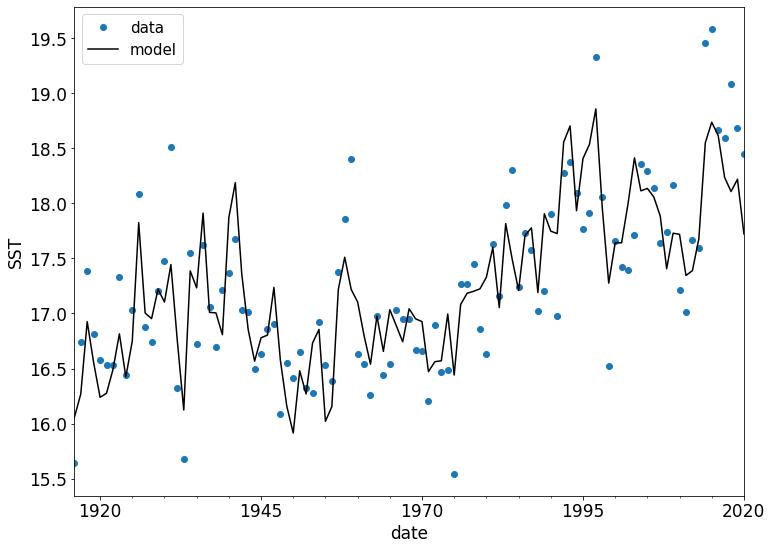

In [119]:
fig = plt.figure()
fig.set_size_inches((12, 9))
ax = data.SST.plot(ylabel='SST', label='data', marker='o', ls='')
#
data.best.plot(ax=ax, color='k', label='model')
#
ax.legend(fontsize=15)
#
set_fontsize(ax, 17)

----

# Question 15 -- Final residuals

## Calculate

In [120]:
final_resids = data.SST.values - mod_full.fittedvalues.values

## Independence -- Durbin Waston

In [121]:
dw = durbin_watson(final_resids)
dw

1.5226917595543432

### Mild auto-correlation

## Normality -- Shapiro

In [122]:
shapiro(final_resids)

ShapiroResult(statistic=0.9828082323074341, pvalue=0.1922081559896469)

### Passes 

## Constant Variance

In [123]:
nresid = final_resids.size//2
bartlett(final_resids[:nresid], final_resids[nresid:])

BartlettResult(statistic=1.2134113386868903, pvalue=0.2706575658462491)

### Passes